# EDA

In this EDA, the study dataset are examined in more detail. The goal is to understand the data and the structure of it better.


In [223]:
from textblob_de import TextBlobDE
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud 
from functions import *
from gensim.utils import simple_preprocess
from globalvars import *
from IPython.display import display
from IPython.display import Markdown as md
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pandas_profiling import ProfileReport
import contractions
import gensim
import kaleido
import nltk
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import matplotlib
import matplotlib.pyplot as plt
import plotly.io as pio
import re
import spacy
import string
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

# download nlp language package
!python -m spacy download de_core_news_lg
!pip install --upgrade spacy

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1091)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1091)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1091)>


You should consider upgrading via the '/Users/dominik/Documents/Masterarbeit-Code/nlp-satisfaction/venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')
Requirement already up-to-date: spacy in ./venv/lib/python3.7/site-packages (3.4.3)
You should consider upgrading via the '/Users/dominik/Documents/Masterarbeit-Code/nlp-satisfaction/venv/bin/python3 -m pip install --upgrade pip' command.


### Load Data

In [71]:
## Import dataframe
filelocation = 'data/DataClean'
df = pd.read_feather(filelocation)

## load config file
config = pd.read_excel('config/config.xlsx',sheet_name='fragecodes')

invites_month = pd.read_excel('config/config.xlsx',sheet_name='invites')
#invites_month['yearmonth']= invites_month['yearmonth'].dt.to_period('M')


In [72]:
#df.info()

In [73]:
#df[df['u_fahrausweis']=='Normales Billett'].sort_values('u_date',ascending=True)

## EDA

Possiblity to filter on a specific timerange. The filter is applied the whole EDA.

In [74]:
startdate = '2019-01-01'
enddate = '2022-10-31'

# Apply time selection for all DataFrames
df= df[(df['u_date'] > startdate) & (df['u_date'] < enddate)]

### Overview

#### General DataFrame Overview

In [75]:
df = df.sort_values("u_date",ascending=False)

In [76]:
df.head(5)

participant_id     u_date  \
225817          583530 2022-10-30   
226068          583884 2022-10-30   
225782          583485 2022-10-30   
226048          583862 2022-10-30   
226052          583866 2022-10-30   

                                                Kommentar  wime_personal  \
225817  Klimaanlage / Heizung wechselte leider ständig...            NaN   
226068                                               None            NaN   
225782                                               None            NaN   
226048  Am Morgen des gleichen Tages fuhren wir mit ei...            NaN   
226052  Wir haben 4 Veloplätze reserviert. Die Zuteilu...            NaN   

        wime_komfort  wime_sauberkeit  wime_puenktlich  wime_platzangebot  \
225817          75.0            100.0            100.0               75.0   
226068           NaN              NaN              NaN                NaN   
225782         100.0             75.0            100.0              100.0   
226048           NaN              NaN              NaN                NaN   
226052           NaN              NaN              NaN                NaN   

        wime_gesamtzuf  wime_preis_leistung  ...  ft_vm_kurz  ft_zielort_uic  \
225817            75.0                 75.0  ...          IC         8503000   
226068             NaN                 75.0  ...         NaN             NaN   
225782           100.0                100.0  ...           S         8503301   
226048             NaN                 75.0  ...         NaN             NaN   
226052             NaN                 75.0  ...         NaN             NaN   

                fg_abfahrt          fg_ankunft fg_startort_uic fg_zielort_uic  \
225817 2022-11-26 10:03:00 2022-11-26 13:27:00         8505479        8506000   
226068                 NaT                 NaT             NaN            NaN   
225782 2022-11-26 09:25:00 2022-11-26 09:33:00         8503303        8503301   
226048                 NaT                 NaT             NaN            NaN   
226052                 NaT                 NaT             NaN            NaN   

       fg_startort           fg_zielort ft_startort           ft_zielort  
225817      Lodano           Winterthur  Bellinzona            Zürich HB  
226068    Zofingen  Rodersdorf, Station    Zofingen  Rodersdorf, Station  
225782      Illnau         Pfäffikon ZH      Illnau         Pfäffikon ZH  
226048        Chur       Rafz, Friedhof        Chur       Rafz, Friedhof  
226052      Lugano            Zürich HB      Lugano            Zürich HB  

[5 rows x 41 columns]

In [77]:
df.shape

(226081, 41)

In [78]:
## Add additional date columns for easier vizualization
df.insert(loc=2, column = 'year', value=df['u_date'].dt.year) #create additional year col for viz
df.insert(loc=3, column = 'month', value=df['u_date'].dt.month) #create additional month col for viz
df['yearmonth'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1)) #create additional yearmonth col for viz
#df['yearmonth']= df['u_date'].dt.to_period('M')

### TextData

In [79]:

df_text = df.dropna(subset=["Kommentar"])

#### Number of comments per month

In [80]:
df_text_counts = pd.DataFrame(df_text.groupby(['yearmonth'])['participant_id'].count()).reset_index()
df_participantstotals_counts = pd.DataFrame(df.groupby(['yearmonth'])['participant_id'].count()).reset_index()

In [81]:
# Merge Dataframes
df_counts_month = df_text_counts.merge(df_participantstotals_counts, on='yearmonth', how='left')
df_counts_month = df_counts_month.merge(invites_month, on='yearmonth', how='left') # join aount of invites
df_counts_month.rename(columns = {'participant_id_x':'Anzahl Befragte mit Kommentar','participant_id_y':'Anzahl Befragte'}, inplace = True)
df_counts_month['Kommentar Ratio in %'] = (df_counts_month['Anzahl Befragte mit Kommentar']/df_counts_month['Anzahl Befragte'])*100
df_counts_month['Rücklauf Ratio in %'] = (df_counts_month['Anzahl Befragte']/df_counts_month['Anzahl Einladungen'])*100

In [82]:
df_counts_month.describe()

Anzahl Befragte mit Kommentar  Anzahl Befragte  Anzahl Einladungen  \
count                      44.000000        44.000000           44.000000   
mean                     1387.159091      5138.204545        75714.863636   
std                       495.655823      1679.551554        20271.876486   
min                       637.000000      2314.000000        42605.000000   
25%                       999.750000      4018.750000        60434.000000   
50%                      1328.500000      5111.500000        67946.500000   
75%                      1717.500000      5903.500000        89381.250000   
max                      2698.000000      9898.000000       122993.000000   

       Kommentar Ratio in %  Rücklauf Ratio in %  
count             44.000000            44.000000  
mean              26.786723             6.743027  
std                2.545399             0.950641  
min               22.506454             4.752712  
25%               24.669403             6.196167  
50%               26.288042             6.726789  
75%               28.541672             7.096513  
max               31.907954             9.891194

In [83]:
len(df)

226081

In [84]:
## plot settings
color_discrete_sequence = color_discrete_sequence #imported from globalvars.py
template = template ##imported from globalvars.py

In [85]:
df_counts_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 0 to 43
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   yearmonth                      44 non-null     datetime64[ns]
 1   Anzahl Befragte mit Kommentar  44 non-null     int64         
 2   Anzahl Befragte                44 non-null     int64         
 3   Anzahl Einladungen             44 non-null     float64       
 4   Kommentar Ratio in %           44 non-null     float64       
 5   Rücklauf Ratio in %            44 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 2.4 KB


In [86]:
fig = px.line(df_counts_month,
              x="yearmonth",
              y=['Anzahl Befragte mit Kommentar', 'Anzahl Befragte','Anzahl Einladungen'],
              color_discrete_sequence=color_discrete_sequence,
              template=template)

fig.update_layout(
    title="Anzahl Einladungen, Anzahl Befragungen & Anzahl Befragte mit Kommentar",
    yaxis_title='',
    xaxis_title='',
    width=1200, 
    height=600,
    legend_title="")

fig.update_traces(line_width=2)
fig.update_traces(patch={"line": {"dash": 'dot'}}, selector={"legendgroup": "Anzahl Einladungen"})

fig.update_yaxes(type="log") 

fig.add_vrect(
    x0="2020-03-01",
    x1="2020-05-31",
    line_width=0,
    fillcolor="#0B1F26",
    opacity=0.2,
    annotation_text="Pause",
    annotation_position="top left",
    annotation_font_size=10,
    annotation_font_color="#0B1F26",
)

fig.update_traces(connectgaps=False)

fig.show()

pio.write_image(fig,"images/fig-anteil_befragte_und_anzahl_kommentare.svg") #save fig as svg

In [87]:
fig = px.line(df_counts_month,
              x="yearmonth",
              y='Kommentar Ratio in %',
              color_discrete_sequence=color_discrete_sequence,
              template=template)
fig.update_layout(
    title="Anteil Befragte mit Kommentar",
    yaxis_title='Anteil in %',
    xaxis_title='Monat',
    width=1200, 
    height=600,
    )
fig.update_traces(line_width=2)
#fig.update_yaxes(range=(0,40))


# show legend for singel line plots
fig['data'][0]['showlegend'] = True
fig['data'][0]['name'] = 'Anteil Kommentare in %'

fig.update_yaxes(range=(21,35))

fig.show()

pio.write_image(fig,"images/fig-anteil-befragte-mit-kommentar.svg") #save fig as svg

In [88]:
df_counts_month.describe()

Anzahl Befragte mit Kommentar  Anzahl Befragte  Anzahl Einladungen  \
count                      44.000000        44.000000           44.000000   
mean                     1387.159091      5138.204545        75714.863636   
std                       495.655823      1679.551554        20271.876486   
min                       637.000000      2314.000000        42605.000000   
25%                       999.750000      4018.750000        60434.000000   
50%                      1328.500000      5111.500000        67946.500000   
75%                      1717.500000      5903.500000        89381.250000   
max                      2698.000000      9898.000000       122993.000000   

       Kommentar Ratio in %  Rücklauf Ratio in %  
count             44.000000            44.000000  
mean              26.786723             6.743027  
std                2.545399             0.950641  
min               22.506454             4.752712  
25%               24.669403             6.196167  
50%               26.288042             6.726789  
75%               28.541672             7.096513  
max               31.907954             9.891194

#### Minimal, maximal and average length of Kommentar

In [89]:
## Add basic text features
df_text["Kommentar"] = remove_redundant_whitespaces(df_text["Kommentar"]) #note: imported function "remove_redundant_whitespaces"
df_text = add_basic_textfeatures(df_text,"Kommentar")

/Users/dominik/Documents/Masterarbeit-Code/nlp-satisfaction/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [90]:
df_text_average_character_median_per_month = pd.DataFrame(df_text.groupby(['yearmonth'])['Kommentar_Character'].median()).reset_index()
df_text_average_character_mean_per_month = pd.DataFrame(df_text.groupby(['yearmonth'])['Kommentar_Character'].mean()).reset_index()

In [91]:
# Merge Dataframes
df_text_character_counts_month = df_text_average_character_median_per_month.merge(df_text_average_character_mean_per_month, on='yearmonth', how='left')
df_text_character_counts_month.rename(columns = {'Kommentar_Character_x':'Median Characters','Kommentar_Character_y':'Mittelwert Characters'}, inplace = True)

In [92]:
fig = px.line(df_text_character_counts_month,
              x="yearmonth",
              y=['Median Characters','Mittelwert Characters'],
              color_discrete_sequence=color_discrete_sequence,
              template=template)
fig.update_layout(
    title="Freitextkommentare: Characters-Median & Characters-Mittelwert in Vergleich",
    yaxis_title='Anzahl',
    xaxis_title='Monat',
    width=1200, 
    height=600,
    legend_title="")
fig.update_traces(line_width=2)
fig.update_yaxes(range=(81,200))



fig.show()

pio.write_image(fig,"images/fig-Characters-median-mittelwert.svg") #save fig as svg

In [93]:
fig = px.histogram(
    df_text,
    x="Kommentar_Character",
    range_x = [1,1500],
    title="Freitextkommentare: Häufigkeitsverteilung Länge der Kommentare (Characters)",
    color = "year",
    labels={'Kommentar_Character':'Anzahl Character'},
    color_discrete_sequence=color_discrete_sequence,
    width=1200, 
    height=600,
    template=template)
    
fig.update_layout(yaxis_title="Anzahl Kommentare")

# Overlay both histograms
fig.update_layout(barmode='overlay')

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.4)

fig.show()

pio.write_image(fig,"images/fig-character-hist.svg") #save fig as svg

In [94]:
df_text.describe()

participant_id          year         month  wime_personal  \
count    61035.000000  61035.000000  61035.000000   22575.000000   
mean    360513.030982   2020.353043      6.530024      88.176080   
std     176093.183053      1.181380      3.298886      19.895906   
min      41305.000000   2019.000000      1.000000       0.000000   
25%     120151.500000   2019.000000      4.000000      77.777778   
50%     406700.000000   2020.000000      7.000000     100.000000   
75%     501985.500000   2021.000000      9.000000     100.000000   
max     587992.000000   2022.000000     12.000000     100.000000   

       wime_komfort  wime_sauberkeit  wime_puenktlich  wime_platzangebot  \
count  48969.000000     49642.000000     49816.000000       50110.000000   
mean      74.256219        76.587254        86.970775          75.475121   
std       25.702607        23.187087        24.406390          30.283246   
min        0.000000         0.000000         0.000000           0.000000   
25%       55.555556        66.666667        77.777778          55.555556   
50%       75.000000        77.777778       100.000000          88.888889   
75%      100.000000       100.000000       100.000000         100.000000   
max      100.000000       100.000000       100.000000         100.000000   

       wime_gesamtzuf  wime_preis_leistung  wime_fahrplan  wime_oes_fahrt  \
count    52122.000000         57118.000000   60178.000000    47609.000000   
mean        78.716921            67.814340      78.235632       89.411666   
std         23.358262            29.246846      27.668477       16.169346   
min          0.000000             0.000000       0.000000        0.000000   
25%         75.000000            50.000000      66.666667       77.777778   
50%         77.777778            75.000000      88.888889      100.000000   
75%        100.000000           100.000000     100.000000      100.000000   
max        100.000000           100.000000     100.000000      100.000000   

            S_alter       u_preis  Kommentar_Character  Kommentar_Tokens  \
count  60884.000000  53544.000000         61035.000000      61035.000000   
mean      51.928290     43.779191           173.385074         26.894175   
std       15.581898    276.715213           181.906399         28.602560   
min       10.000000      0.000000             0.000000          0.000000   
25%       41.000000      8.800000            58.000000          9.000000   
50%       54.000000     17.000000           119.000000         18.000000   
75%       64.000000     30.600000           219.000000         34.000000   
max       98.000000   6300.000000          2047.000000        347.000000   

       Kommentar_Types  Kommentar_TTR  
count     61035.000000   60958.000000  
mean         23.981945      94.695901  
std          22.564262       6.905334  
min           0.000000      33.333333  
25%           8.000000      90.697674  
50%          17.000000     100.000000  
75%          32.000000     100.000000  
max         230.000000     100.000000

In [95]:
#df_text.quantile(0.9) 

In [96]:
#df_text[df_text.year == 2019][df_text.Kommentar_Character == 199]

In [97]:
df_text

participant_id     u_date  year  month  \
225817          583530 2022-10-30  2022     10   
226048          583862 2022-10-30  2022     10   
226052          583866 2022-10-30  2022     10   
226062          583878 2022-10-30  2022     10   
226063          583879 2022-10-30  2022     10   
...                ...        ...   ...    ...   
892              51631 2019-01-02  2019      1   
890              51628 2019-01-02  2019      1   
1023             51805 2019-01-02  2019      1   
1018             51799 2019-01-02  2019      1   
887              51623 2019-01-02  2019      1   

                                                Kommentar  wime_personal  \
225817  Klimaanlage / Heizung wechselte leider ständig...            NaN   
226048  Am Morgen des gleichen Tages fuhren wir mit ei...            NaN   
226052  Wir haben 4 Veloplätze reserviert. Die Zuteilu...            NaN   
226062  Anzeige, ob viel Menschen diesen Zug benützen!...            NaN   
226063                                       Zug war voll            NaN   
...                                                   ...            ...   
892     in den IR in der 1. klasse bequemere sitze ein...     100.000000   
890     Retourfahrten, d.h. Luzern - Wohlen/Bremgarten...      77.777778   
1023    Die signalisation des gleises 50 in Zofingen w...            NaN   
1018    die lüftung (frischluft) der klimatisierten sb...            NaN   
887     Ich hätte gehofft, dass auf diese Verbindung S...            NaN   

        wime_komfort  wime_sauberkeit  wime_puenktlich  wime_platzangebot  \
225817     75.000000       100.000000       100.000000          75.000000   
226048           NaN              NaN              NaN                NaN   
226052           NaN              NaN              NaN                NaN   
226062           NaN              NaN              NaN                NaN   
226063           NaN              NaN              NaN                NaN   
...              ...              ...              ...                ...   
892        44.444444       100.000000       100.000000         100.000000   
890        77.777778        66.666667       100.000000          66.666667   
1023       77.777778       100.000000       100.000000         100.000000   
1018       66.666667        44.444444        66.666667          66.666667   
887        77.777778        55.555556       100.000000         100.000000   

        ...  fg_zielort_uic          fg_startort           fg_zielort  \
225817  ...         8506000               Lodano           Winterthur   
226048  ...             NaN                 Chur       Rafz, Friedhof   
226052  ...             NaN               Lugano            Zürich HB   
226062  ...             NaN           Winterthur         Pilatus Kulm   
226063  ...             NaN            Zürich HB            Basel SBB   
...     ...             ...                  ...                  ...   
892     ...         8508100          Wallisellen           Langenthal   
890     ...         8505000  Bremgarten Isenlauf               Luzern   
1023    ...         8502196         Dagmersellen  Unterentfelden Post   
1018    ...         8506121           Frauenfeld           Romanshorn   
887     ...         8504419      Zürich Oerlikon            Biel Mett   

              ft_startort      ft_zielort  yearmonth Kommentar_Character  \
225817         Bellinzona       Zürich HB 2022-10-01                  63   
226048               Chur  Rafz, Friedhof 2022-10-01                 376   
226052             Lugano       Zürich HB 2022-10-01                 342   
226062         Winterthur    Pilatus Kulm 2022-10-01                 111   
226063          Zürich HB       Basel SBB 2022-10-01                  12   
...                   ...             ...        ...                 ...   
892     Zürich Altstetten      Langenthal 2019-01-01                  51   
890              Rotkreuz          Luzern 2019-01-01                 104   
1023    

- Median of 122 Characters per Comment (140 original Twitter length)
- Median of 19 Tokens per comment.
- Median TTR of 98.

In [98]:
satisfaction_codes = config[config['vartype'] == 'satisfaction']['fragecode'] #loading satisfaction codes from config
df_text['rating_selected_average'] = df_text[satisfaction_codes].mean(axis=1) #calculate mean ratings 

satisfaction_category = pd.cut(df_text['rating_selected_average'],bins=[0,25,50,75,100],labels=["<25 Punkte","25-50 Punkte","50-75 Punkte","75-100 Punkte"])
df_text.insert(49,"rating_selected_average_group",satisfaction_category)

satisfaction_category_spontan = pd.cut(df_text['wime_gesamtzuf'],bins=[0,25,50,75,100],labels=["<25 Punkte","25-50 Punkte","50-75 Punkte","75-100 Punkte"])
df_text.insert(50,"rating_wime_gesamtzuf_group",satisfaction_category_spontan)

In [99]:
# x and y given as array_like objects
fig = px.scatter(
    df_text,
    x='Kommentar_Character', 
    y='Kommentar_TTR',
    opacity = 1,
    color_discrete_sequence =color_discrete_sequence,
    color = "rating_selected_average_group",
    marginal_x='box',
    #color_continuous_scale=[(0,'red'), (0.75, 'orange'), (1,'green')]
                 )

fig.update_layout(
    title="Kommentarlänge und Type-Token Ratio im Vergleich mit Zufriedenheitsbewertung",
    yaxis_title='TTR in %',
    xaxis_title='Kommentarlänge in Character',
    width=1200, 
    height=600,
    legend_title="")

#fig.update_yaxes(range=(55,105))

fig.show()

pio.write_image(fig,"images/fig-Characters-TTR_scatter.svg") #save fig as svg

# Pandas Profiling TextData
profile = ProfileReport(
    df_text[
        [
            #"participant_id",
            #"u_date",
            "Kommentar",
            "Kommentar_Character",
            "Kommentar_TTR",
            "Kommentar_Tokens",
            "Kommentar_Types",
            'rating_selected_average',
        ]
    ],
    title="TextData",
    lazy=False,
    dark_mode=True,
)

profile.to_file("html/ProfilingTextData.html")


In [100]:
## Tokenize
from nltk.tokenize import word_tokenize
df_text['tokenized'] = df_text['Kommentar'].apply(word_tokenize)

In [101]:
## Lower
df_text['lower'] = df_text['tokenized'].apply(lambda x: [word.lower() for word in x])

In [102]:
## Removing Punctuations
punc = string.punctuation
df_text['no_punc'] = df_text['lower'].apply(lambda x: [word for word in x if word not in punc])

In [103]:
## Removing German Stopwords
stop_words = set(stopwords.words('german'))
df_text['stopwords_removed'] = df_text['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])

In [104]:
## Add string Version of lemmatized column to analyse sentiment
df_text['stopwords_removed_str'] = [' '.join(map(str,l)) for l in df_text['stopwords_removed']]

In [105]:
## Lemmatize
def lemmatize_words(texts, stop_words=stop_words):
    texts_out = []
    nlp = spacy.load('de_core_news_lg')
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


# Apply function
df_text['lemmatized'] = lemmatize_words(df_text['stopwords_removed'])

In [106]:
## Add string Version of lemmatized column to analyse sentiment
df_text['lemma_str'] = [' '.join(map(str,l)) for l in df_text['lemmatized']]

In [107]:
## PoS Tagging
def pos_tagging(texts):
    tags = []
    for x in texts:
        blob = TextBlobDE(x)
        tags.append(blob.tags)
    return tags

# Apply function
df_text['pos_tagged'] = pos_tagging(df_text['lemma_str'])

In [108]:
############## Export ############## 
df_text = df_text.reset_index(drop=True)
df_text.to_feather('data/DataText') # store data in feather file

In [109]:
############## Import ############## 
filelocation = 'data/DataText'
df_text = pd.read_feather(filelocation)

### N-Grams

In [110]:
# create sub-dataframes for year specific plots
df_text_2019 = df_text[df_text['year']==2019] # FIlter on specific year (optional)
df_text_2020 = df_text[df_text['year']==2020] # FIlter on specific year (optional)
df_text_2021 = df_text[df_text['year']==2021] # FIlter on specific year (optional)
df_text_2022 = df_text[df_text['year']==2022] # FIlter on specific year (optional)

N-grams are used to describe the number of words used as observation points, e.g., unigram means singly-worded, bigram means 2-worded phrase, and trigram means 3-worded phrase. In order to do this, we use scikit-learn’s CountVectorizer function.

In [195]:
dataframe_selected = df_text
label_plots = "All-Years"
dataframe_selected_len = len(dataframe_selected )

#### Unigrams

In [196]:
common_words = get_top_n_words(dataframe_selected['stopwords_removed_str'], 20) #NOTE: function is importet from other .py file

unigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])
unigrams['count_relative']=(unigrams['count']/dataframe_selected_len)*100
unigrams

word  count  count_relative
0       zug  16589       27.179487
1      mehr  11836       19.392152
2       sbb   8211       13.452937
3    zürich   5733        9.392971
4      wäre   5562        9.112804
5     immer   5432        8.899812
6    klasse   5030        8.241173
7       app   4969        8.141230
8      züge   4331        7.095929
9   bahnhof   4077        6.679774
10    platz   3476        5.695093
11     bern   3449        5.650856
12    fahrt   3436        5.629557
13      oft   3359        5.503400
14       ab   3172        5.197018
15  strecke   3117        5.106906
16   leider   3015        4.939789
17    wagen   2937        4.811993
18    schon   2907        4.762841
19      gut   2839        4.651430

In [197]:
fig = px.bar(unigrams.sort_values('count_relative', ascending=True),
    x='count_relative', 
    y='word',
    opacity = 1,
    color_discrete_sequence =color_discrete_sequence
                 )

fig.update_layout(
    title="Top 20 - Unigrams ("+label_plots+")",
    yaxis_title='',
    xaxis_title='Relative Häufigkeit',
     xaxis=dict(ticksuffix="%"),
    width=400, 
    height=800,
    legend_title="")

#fig.update_yaxes(range=(55,105))

fig.show()

pio.write_image(fig,"images/fig-Unigrams-"+label_plots+"-barchart.svg") #save fig as svg

#### Bigrams

In [198]:
common_words_bigrams = get_top_n_bigram(dataframe_selected['stopwords_removed_str'], 20)

bigrams = pd.DataFrame(common_words_bigrams, columns = ['word' , 'count'])
bigrams['count_relative']=(bigrams['count']/dataframe_selected_len)*100
bigrams

word  count  count_relative
0              sbb app   1399        2.292127
1           mehr platz    977        1.600721
2            st gallen    842        1.379536
3            zürich hb    809        1.325469
4           wäre schön    588        0.963382
5          vielen dank    483        0.791349
6          viele leute    386        0.632424
7   minuten verspätung    371        0.607848
8          wenig platz    354        0.579995
9          arth goldau    350        0.573441
10          zug zürich    334        0.547227
11     mehr sitzplätze    330        0.540673
12          mobile app    319        0.522651
13  freundliche grüsse    318        0.521013
14           wäre toll    313        0.512821
15        platz gepäck    294        0.481691
16  wäre wünschenswert    291        0.476776
17        klasse wagen    290        0.475137
18        letzter zeit    283        0.463668
19            wäre gut    269        0.440731

In [199]:
fig = px.bar(bigrams.sort_values('count_relative', ascending=True),
    x='count_relative', 
    y='word',
    opacity = 1,
    color_discrete_sequence =color_discrete_sequence
                 )

fig.update_layout(
    title="Top 20 - Bigrams ("+label_plots+")",
    yaxis_title='',
    xaxis_title='Relative Häufigkeit',
    xaxis=dict(ticksuffix="%"),
    width=400, 
    height=800,
    legend_title="")

#fig.update_yaxes(range=(55,105))

fig.show()

pio.write_image(fig,"images/fig-Bigrams-"+label_plots+"-barchart.svg") #save fig as svg

#### Trigrams

In [200]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [201]:
common_words_bigrams = get_top_n_bigram(dataframe_selected['stopwords_removed_str'], 20)

bigrams = pd.DataFrame(common_words_bigrams, columns = ['word' , 'count'])
bigrams['count_relative']=(bigrams['count']/dataframe_selected_len)*100
bigrams

word  count  count_relative
0              sbb app   1399        2.292127
1           mehr platz    977        1.600721
2            st gallen    842        1.379536
3            zürich hb    809        1.325469
4           wäre schön    588        0.963382
5          vielen dank    483        0.791349
6          viele leute    386        0.632424
7   minuten verspätung    371        0.607848
8          wenig platz    354        0.579995
9          arth goldau    350        0.573441
10          zug zürich    334        0.547227
11     mehr sitzplätze    330        0.540673
12          mobile app    319        0.522651
13  freundliche grüsse    318        0.521013
14           wäre toll    313        0.512821
15        platz gepäck    294        0.481691
16  wäre wünschenswert    291        0.476776
17        klasse wagen    290        0.475137
18        letzter zeit    283        0.463668
19            wäre gut    269        0.440731

In [202]:
common_words_trigram = get_top_n_trigram(dataframe_selected['stopwords_removed_str'], 20)

trigrams = pd.DataFrame(common_words_trigram, columns = ['word' , 'count'])
trigrams['count_relative']=(trigrams['count']/dataframe_selected_len)*100
trigrams

word  count  count_relative
0              sbb mobile app    150        0.245761
1           mehr platz gepäck    132        0.216269
2            mehr platz velos     86        0.140903
3           mehr klasse wagen     76        0.124519
4        lässt wünschen übrig     63        0.103219
5   darauf aufmerksam gemacht     60        0.098304
6          wenig platz gepäck     53        0.086835
7                 via sbb app     51        0.083559
8            st gallen zürich     49        0.080282
9        geehrte damen herren     46        0.075367
10          mehr platz klasse     44        0.072090
11               ab zürich hb     43        0.070451
12           zürich st gallen     42        0.068813
13              zug zürich hb     41        0.067175
14  mehr direkte verbindungen     40        0.065536
15              zug st gallen     39        0.063898
16        mehr wagen anhängen     39        0.063898
17            fahre gerne zug     37        0.060621
18        strecke zürich bern     36        0.058983
19        strecke bern zürich     36        0.058983

In [218]:
fig = px.bar(trigrams.sort_values('count_relative', ascending=True),
    x='count_relative', 
    y='word',
    opacity = 1,
    color_discrete_sequence =color_discrete_sequence
                 )

fig.update_layout(
    title="Top 20 - Trigrams ("+label_plots+")",
    yaxis_title='',
    xaxis_title='Relative Häufigkeit',
    xaxis=dict(ticksuffix="%"),
    width=400, 
    height=800,
    legend_title="")

#fig.update_yaxes(range=(55,105))

fig.show()

pio.write_image(fig,"images/fig-Trigrams-"+label_plots+"-barchart.svg") #save fig as svg

### Satisfaction Data

In [219]:
#df_text.stopwords_removed_str.str.cat(sep='')

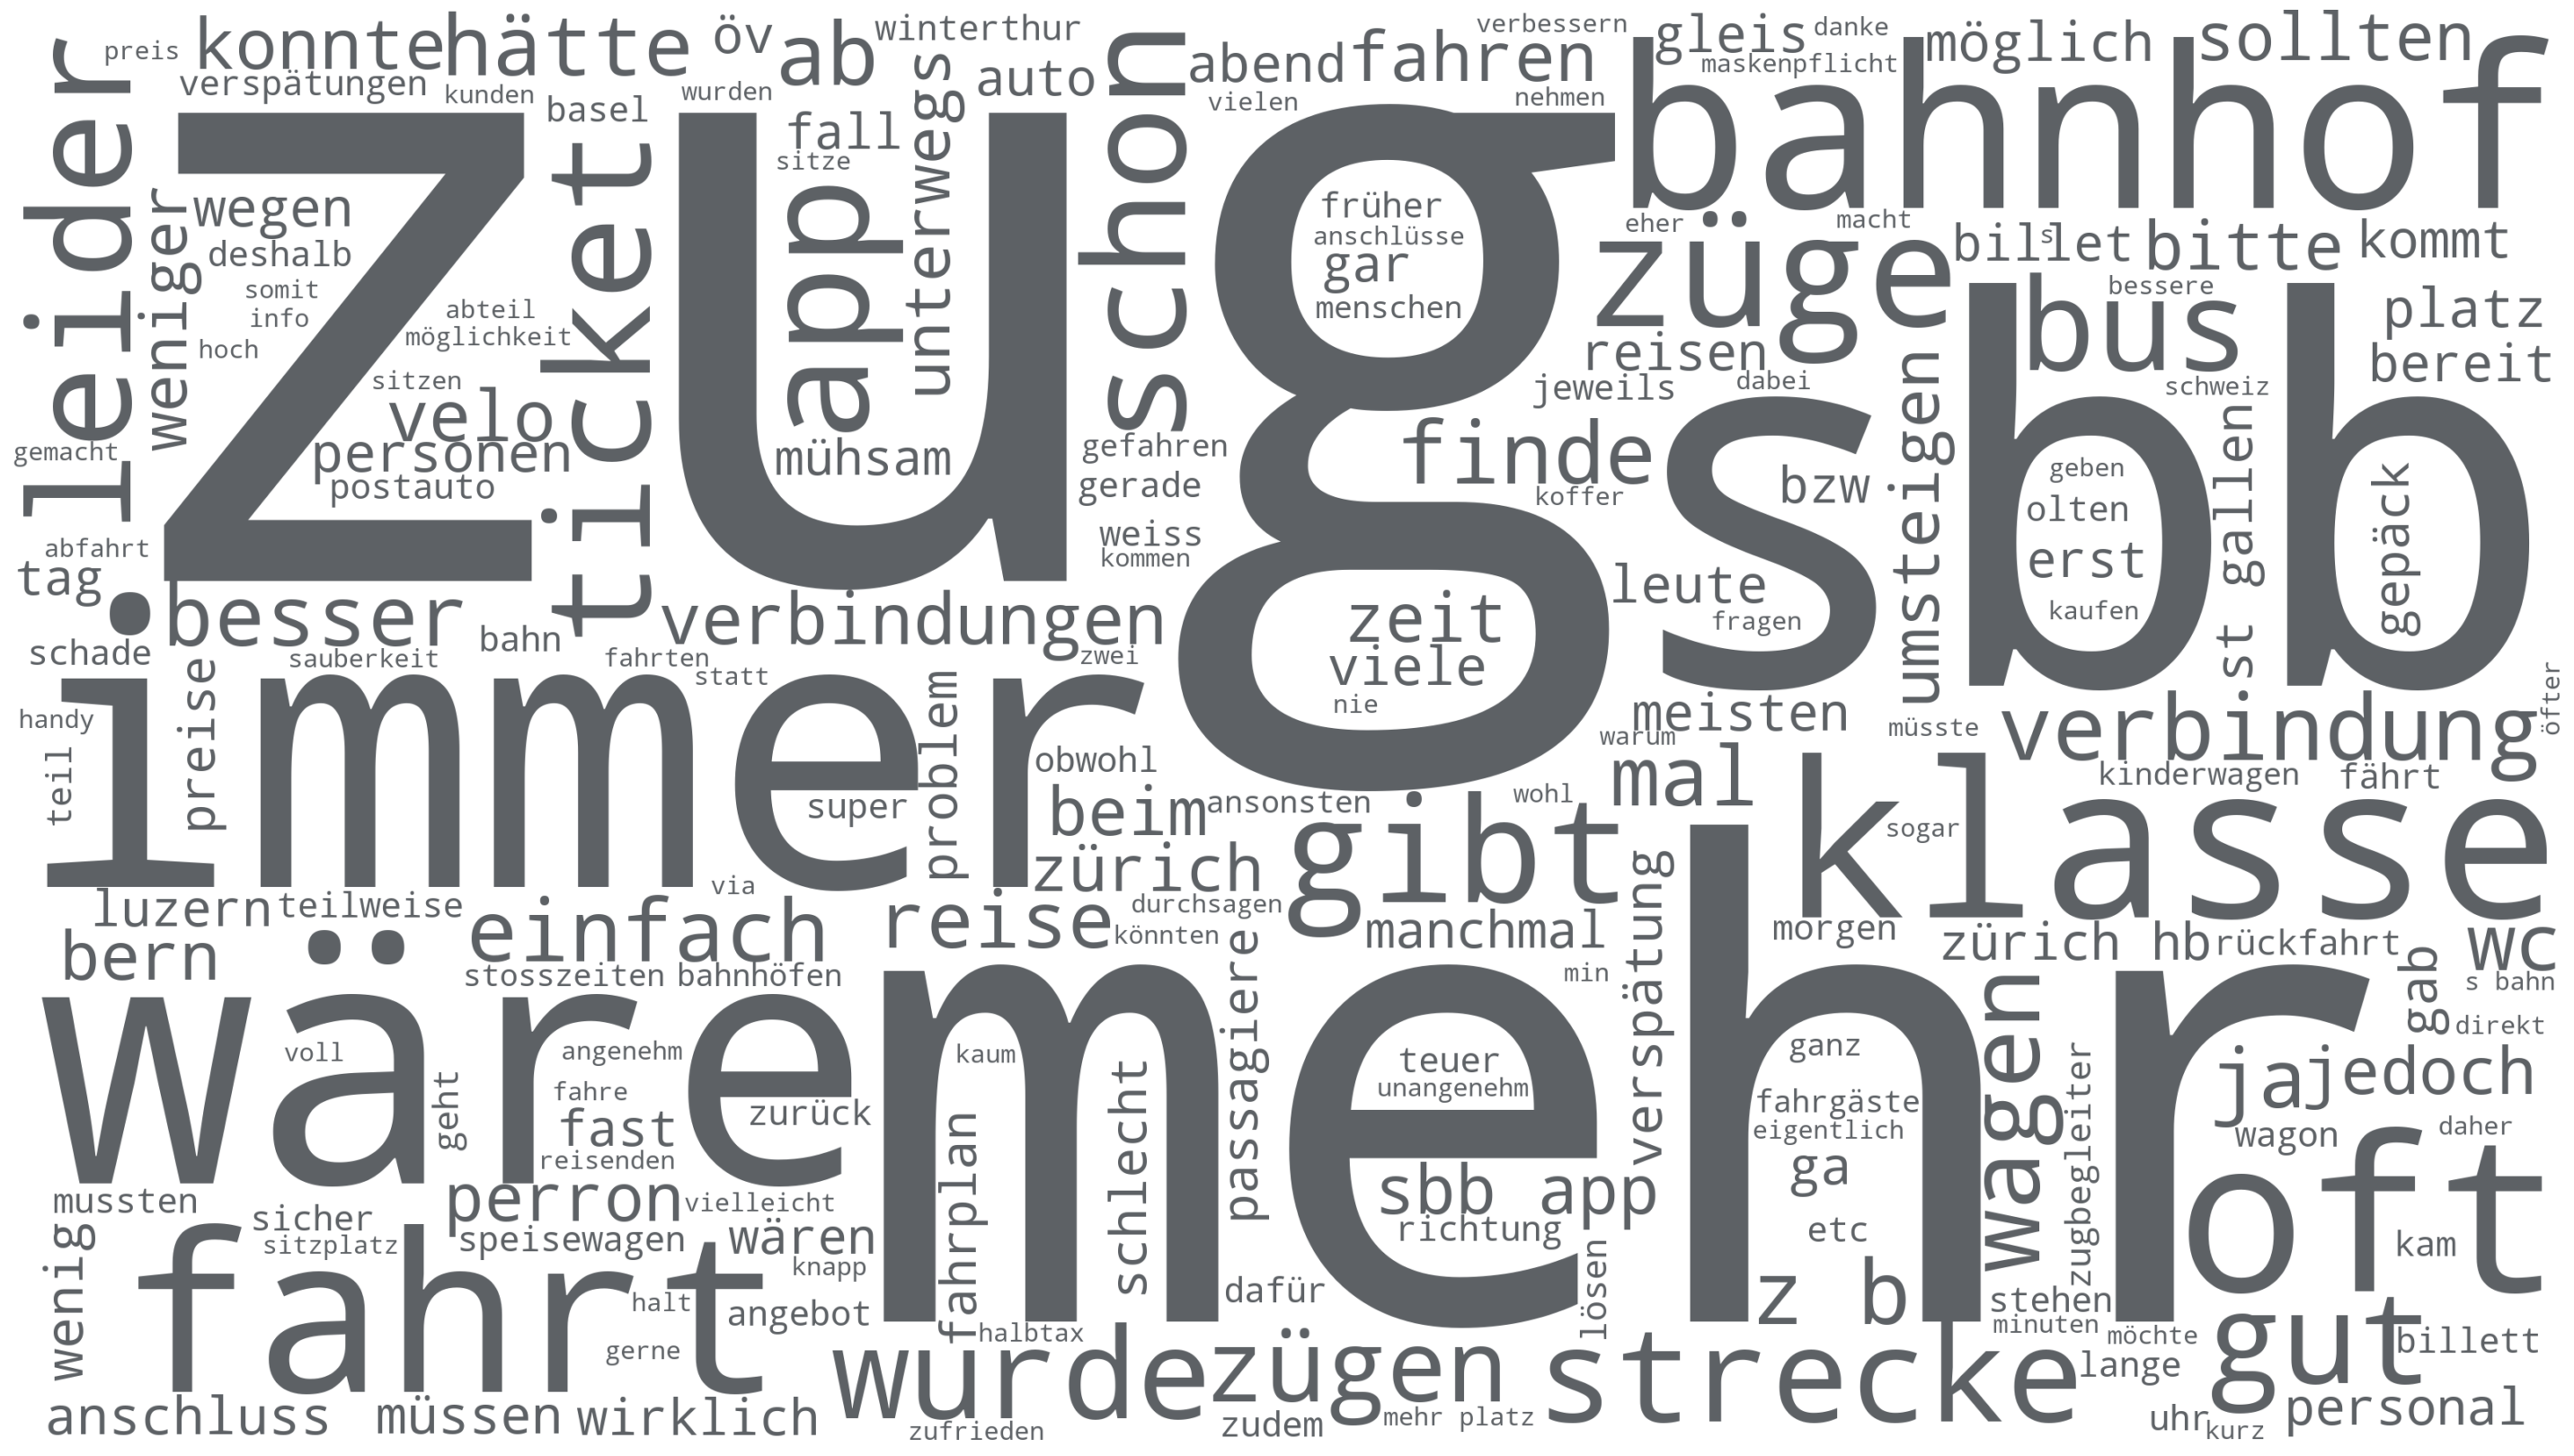

In [245]:
# Now let's generate a wordcloud for some reviews
font_color = "#5D6165"


wordcloud = WordCloud(width = 3200, height = 1800, 
                background_color ='white',
                color_func=lambda *args, **kwargs: font_color,
                min_font_size = 10).generate(df_text.stopwords_removed_str.str.cat())
  
# plot the WordCloud image                      
plt.figure(figsize = (32, 16), facecolor = None) 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [212]:
#df_text.stopwords_removed_str.str.cat(sep='').replace(" ", "").replace("-", "").replace(".", "")

"klimaanlageheizungwechselteleiderständigwarmkaltmorgengleichentagesfuhreniczugdbzürichchurganzezugaussentotalschmutziginklscheibenkonntekaumlandschaftgeniesseninnenstandteppichschmutzeinfachgruusigsolltensbbschleunigstunternehmenabsolutvisitenkarteganzschlechte4veloplätzereserviertzuteilungwagen4allveloseigentlichwäretopjedochwohlkompositiongeändertkonnten2veloswagenabstellenzudemkamenabarthgoldauzweiweiterereserviertevelosreisendenkundenerfreutanzeigemenschenzugbenützenstand„mensch“wenigauslastungzugvollzugvollrollmaterialextremlautbahnhofimmerlautgepfiffenabfahrtzugesvertragenohrengutgrupperfcrafzerfeldteneroeglisaugereisstobwohl44plätzefahrtbellinzonazürichreserviertbestätigtwagenangeschriebenwurdenplätzereserviertverwirrungunzufriedenheitführteservicefunktioniertleidernichtraucherbereichestarkrauchernrauchengenutztschränktnichtrauchersowiekinderstarkfindebelästigendwünschemehrachtsamkeitwertschätzungrauchergetrenntenbereichebeachtennutzenhöflicheransprachesituationantwortengroßent

In [155]:
satisfaction_codes = config[config['vartype'] == 'satisfaction']['fragecode']

In [156]:
# Pandas Profiling Satisfaction Data
profile = ProfileReport(
    df[
        satisfaction_codes
    ],
    title="SatisfactionData",
    lazy=False,
    dark_mode=True,
)

profile.to_file("html/ProfilingSatisfactionData.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]/Users/dominik/Documents/Masterarbeit-Code/nlp-satisfaction/venv/lib/python3.9/site-packages/multimethod/__init__.py:315: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

Summarize dataset:  50%|█████     | 11/22 [00:01<00:01,  7.24it/s, Calculate auto correlation]          


KeyboardInterrupt: 

In [169]:
df_satisfaction = pd.melt(df, id_vars='yearmonth', value_vars=satisfaction_codes) #wide to long and only keep satisfaction questions
df_satisfaction = df_satisfaction.groupby(['yearmonth', 'variable'])[['value']].mean().reset_index() #groupy monthyear and variable

df_satisfaction_average = df_satisfaction.groupby(['yearmonth'])[['value']].mean().reset_index() #groupy monthyear to get overall average
df_satisfaction_average.insert(1,'variable',"Durchschnitt")

df_satisfaction = pd.concat([df_satisfaction,df_satisfaction_average],ignore_index=True).sort_values('yearmonth')

In [170]:
df_satisfaction

yearmonth             variable      value
0   2019-01-01        wime_fahrplan  80.883316
8   2019-01-01      wime_sauberkeit  78.147641
7   2019-01-01      wime_puenktlich  89.092469
6   2019-01-01  wime_preis_leistung  72.451744
5   2019-01-01    wime_platzangebot  79.529696
..         ...                  ...        ...
392 2022-10-01    wime_platzangebot  76.046301
393 2022-10-01  wime_preis_leistung  73.876311
394 2022-10-01      wime_puenktlich  88.249476
395 2022-10-01      wime_sauberkeit  77.739966
439 2022-10-01         Durchschnitt  83.336832

[440 rows x 3 columns]

In [434]:
fig = px.line(
    df_satisfaction,
    x="yearmonth",
    y="value",
    color="variable",
    color_discrete_sequence=color_discrete_sequence,
    template=template,
)

fig.update_layout(
    title="Zufriedenheit mit verschiedenen Aspekten im zeitlichen Verlauf",
    yaxis_title="Zufriedenheit",
    xaxis_title="",
    width=1200, 
    height=600,
    legend_title="",
)

fig.update_traces(line_width=2)
fig.update_yaxes(range=(62, 100))
fig.add_vrect(
    x0="2020-03-25",
    x1="2022-03-01",
    line_width=0,
    fillcolor="#0B1F26",
    opacity=0.1,
    annotation_text="COVID-19 Massnahmen",
    annotation_position="top right",
    annotation_font_size=10,
    annotation_font_color="#0B1F26",
)

fig.add_vrect(
    x0="2020-04-01",
    x1="2020-05-30",
    line_width=0,
    fillcolor="#0B1F26",
    opacity=0.2,
    annotation_text="Pause",
    annotation_position="top left",
    annotation_font_size=10,
    annotation_font_color="#0B1F26",
)



line_width = 2

fig.update_traces(patch={"line": {"dash": 'dot'}}, selector={"legendgroup": "Durchschnitt"})

fig.show()

pio.write_image(fig, "images/fig-satisfaction_zeitreihe.svg")  # save fig as png


### MetaData

In [25]:
meta_codes = config[config['vartype'] == 'meta']['fragecode']

In [63]:
# Pandas Profiling MetaData
profile = ProfileReport(
    df[
        [meta_codes]
    ],
    title="MetaData",
    lazy=False,
    dark_mode=True,
)

profile.to_file("html/ProfilingMetaData.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]/Users/dominik/Documents/nlp-satisfaction/venv/lib/python3.9/site-packages/multimethod/__init__.py:315: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

Summarize dataset:  75%|███████▌  | 33/44 [00:04<00:01,  7.80it/s, Calculate auto correlation]       /Users/dominik/Documents/nlp-satisfaction/venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning:

The input array could not be properly checked for nan values. nan values will be ignored.

/Users/dominik/Documents/nlp-satisfaction/venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning:

The input array could not be properly checked for nan values. nan values will be ignored.

/Users/dominik/Documents/nlp-satisfaction/venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning:

The input array could not be properly checked for nan values. nan values will be ignored.